# NEMA Photoelectric

- Photoelectric interaction in PETALO

In [1]:
import Pkg

In [2]:
Pkg.add.(["HTTP", "Plots", "DataFrames", "HDF5","DrWatson", "StatsBase", "PhysicalConstants"]);

In [3]:
Pkg.add.(["Test"]);

In [4]:
Pkg.add.(["VegaLite","VegaDatasets"]);

In [5]:
Pkg.add.(["LsqFit","GLM"])

2-element Vector{Nothing}:
 nothing
 nothing

In [861]:
Pkg.add("Distributions") 

In [1]:
using Distributions

In [2]:
using LsqFit
using GLM

In [3]:
using HTTP
using Plots
using DataFrames
using HDF5
using DrWatson
using Test
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [4]:
using Glob
using CSV

In [5]:
using Statistics
using StatsBase
using Printf

In [6]:
using Logging

In [102]:
@quickactivate "JPetalo"

In [8]:
pwd()

"/Users/jj/JuliaProjects/JPetalo/notebooks"

In [9]:
datadir()

"/Users/jj/JuliaProjects/JPetalo/data"

In [10]:
srcdir()

"/Users/jj/JuliaProjects/JPetalo/src"

In [285]:
include(srcdir("JPetalo.jl"))

Main.JPetalo

In [13]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

In [65]:
loglevel("Info")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(42) open, 0 bytes waiting))), Debug, Dict{Any, Int64}())

### generate random data for 1 g

In [117]:
dx = Normal(100.0, 5.0)

Normal{Float64}(μ=100.0, σ=5.0)

In [118]:
 data = rand(dx, 50000);

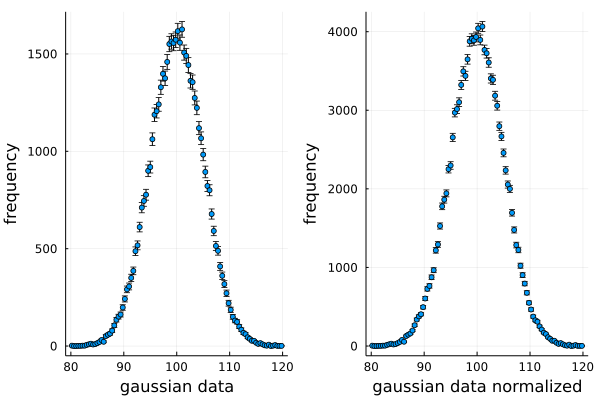

In [253]:
xi = 80.
xs = 120.
h1,p1 = JPetalo.hist1d(data, "gaussian data", 100, xi, xs)
h2,p2 = JPetalo.hist1d(data, "gaussian data normalized", 100, xi, xs, norm=true)
plot(p1,p2)

In [254]:
println("number of bins of histogram = ", length(h.weights))

number of bins of histogram = 100


### Fits 

In [255]:
fit(Normal,data)

Normal{Float64}(μ=100.00783381049618, σ=5.001892434547273)

In [256]:
JPetalo.mean_std(data, xi, xs)

(100.00783094317528, 4.998846054219564)

In [257]:
sum(data) / 100

50003.91690524835

### Fit the histogram

In [258]:
fg = JPetalo.fit_gauss(h);

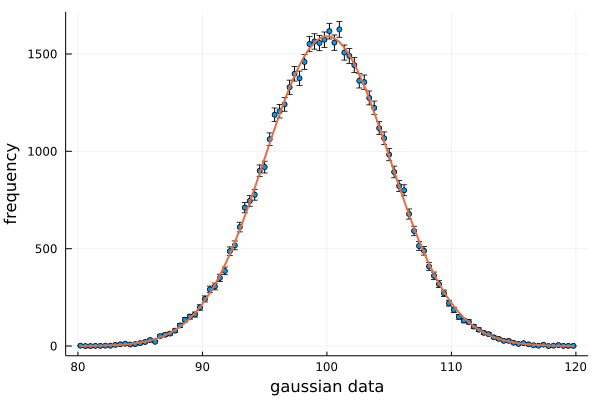

In [259]:
h,p = JPetalo.hist1d(data, "gaussian data", 100, xi, xs, datap=true, fwl=false)
plot!(p, fg.X,fg.Y, lw=2, legend=false)

### Fit the data directly

In [260]:
fg = JPetalo.fit_gauss(data,xi,xs, bins=50);

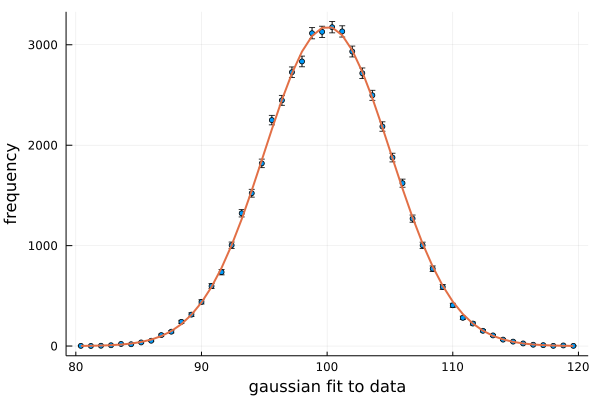

In [261]:
h,p = JPetalo.hist1d(fg.h, "gaussian fit to data", datap = true, markersize=3, fwl=false)
plot!(p, fg.X,fg.Y, lw=2, legend=false)

### Generate random data for two gaussian common mean at zero

In [262]:
d1 = Normal(0.0, 5.0)
d2 = Normal(0.0, 25.0)
dat1 = rand(d1, 50000)
data12 = copy(dat1)
dat2 = rand(d2, 50000)
append!(data12,dat2)
xi = -75.
xs = 75.;


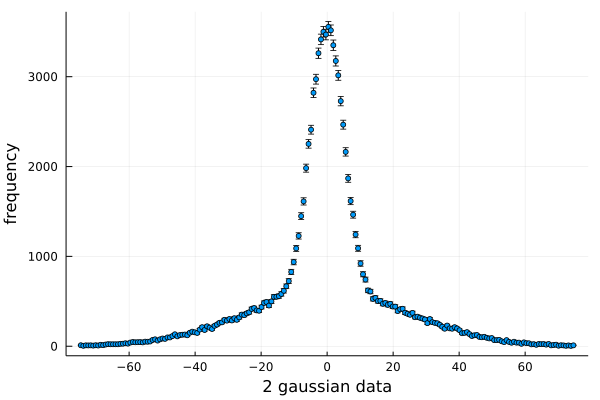

In [263]:
h,p = JPetalo.hist1d(data12, "2 gaussian data", 200, xi, xs)
plot(p)

In [163]:
fg = JPetalo.fit_gauss_fm(data12, xi, xs, bins=200);

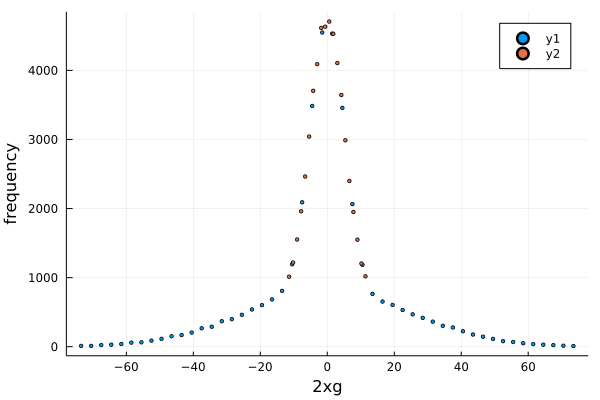

In [265]:
h1,p1 = JPetalo.hist1d(data12, "2 gaussian data", 50, xi, xs, norm=true)
h2,p2 = JPetalo.hist1d(data12, "r gaussian data", 20, -12.0, 12.0, norm=true)
p     = JPetalo.hist1d(h1, h2, "2xg")
plot(p)

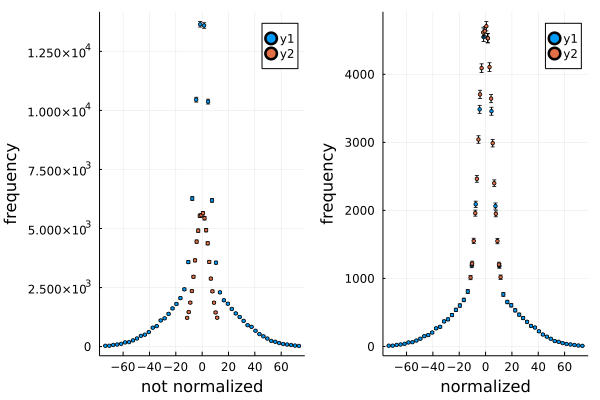

In [271]:
h1,p1 = JPetalo.hist1d(data12, "2 gaussian data", 50, xi, xs)
h2,p2 = JPetalo.hist1d(data12, "r gaussian data", 20, -12.0, 12.0)
p1     = JPetalo.hist1d(h1, h2, "not normalized")
p2     = JPetalo.hist1d(h1, h2, "normalized", norm=true)
plot(p1,p2)

In [ ]:
fitg1(x, xs, bins, xmin, xmax;
	           xgmin, xgmax, fbins=100, norm=true, fm=0.0)

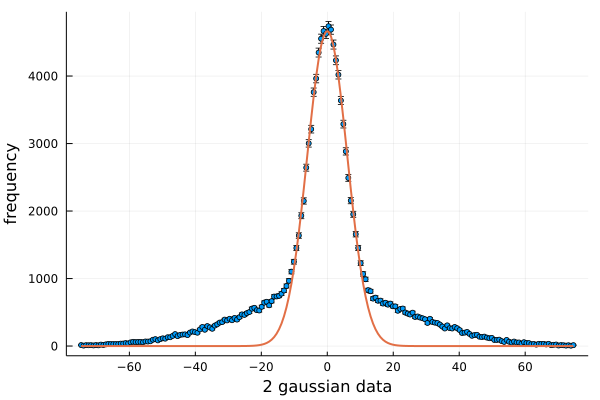

In [276]:
fg,p = JPetalo.fitg1(data12, "2 gaussian data", 200, xi, xs, 
                     xgmin=-12.0, xgmax=12.0, fbins=100)
plot(p)

In [ ]:
fitg2(x, xs, bins, xmin, xmax;
	           xg1min, xg1max, xg2min, xg2max, xgmin, xgmax, cm=0.0
         	   g1bins=100, g2bins=100, gbins=100, norm=false)

sigma1 =  25.143 sigma2 =   5.045

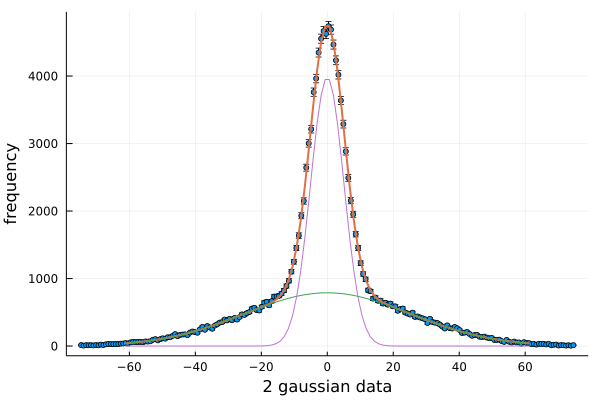

In [286]:
fg, p = JPetalo.fitg2(data12, "2 gaussian data", 200, xi, xs, 
                      xg1min=-62.0, xg1max=-12.0, 
                      xg2min=-12.0, xg2max =12.0, 
                      xgmin =-62.0, xgmax  =62.0)
@printf "sigma1 = %7.3f sigma2 = %7.3f" fg.std[1] fg.std[2]
plot(p)